1. Reading combined extracted data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

In [3]:
pd.set_option('display.max_columns', None)   # show all columns

In [4]:
df = pd.read_csv('combined_accidents.csv')
df.head()

,publish_date,content,time_24h,corrected_date,injury_severity,affected_party,car,motorbike,larger_vehicle,collision,running_over_pedestrian,lost_control,crushed_into_obstacle,overturned,primary_accident_type_code,age,min_age,max_age,location,street,locality,day_of_week_num,rush_hour,rain_today,rain_last_3h,temp_avg,temp_min,temp_max,precip_mm_day,roadworks_nearby
0,2024-12-11,"A 60-year-old woman residing in Swieqi, at aro...",11:15,2024-12-11,grievous,pedestrian,1,0,0,0,1,0,0,0,PED,"['60', '48']",48.0,60.0,"Swieqi, at around 1115hrs, was taken to Mater ...","Swieqi, at around 1115hrs",was taken to Mater Dei Hospital because she wa...,2,0,False,False,14.1,8.9,19.6,0.0,False
1,2024-12-11,"Update:Unfortunately, the 54-year-old Englishm...",17:00,2024-12-11,death,motorcyclist,0,1,0,0,0,1,1,0,FXOBJ,"['54', '54']",54.0,54.0,Mater Dei Hospital,Mater Dei Hospital,NaN,2,1,False,False,14.1,8.9,19.6,0.0,False
2,2024-12-14,"A 17-year-old girl, residing in Qormi, yesterd...",17:30,2024-12-13,serious,pedestrian,1,0,0,1,1,0,0,0,PED,"['17', '52']",17.0,52.0,"Qormi, yesterday, at around 1730hrs, was taken...","Qormi, yesterday, at around 1730hrs, was taken...",Mellieha,6,0,NaN,False,18.8,16.9,21.0,NaN,False
3,2024-12-14,"Yesterday, at around (1945hrs), the police wer...",19:45,2024-12-13,serious,driver,1,0,0,1,0,0,0,0,COLL,"['50', '29']",29.0,50.0,"Dawret il-Gudja, Gudja",Dawret il-Gudja,Gudja,6,0,NaN,False,18.8,16.9,21.0,NaN,True
4,2024-12-14,", police were busy responding to another serio...",19:45,2024-12-14,serious,pedestrian,1,0,1,0,1,0,0,0,PED,"['50', '29']",29.0,50.0,Gudja,Gudja,NaN,5,0,False,False,18.2,15.0,21.3,0.0,False


In [5]:
#dropping columns with dates and content
df.drop(['publish_date', 'content'], axis=1, inplace=True)

2. Value counts and visualisations Part 1: Injury Severity and Affected Party

In [6]:
#injuiry severity value counts
df['injury_severity'].value_counts()

#note: no injuries can be grouped together with minor injuries for analysis purposes. Critical and grievous injuries can be also grouped. 
#the grievous castegory is the largest and can be reduced to balance the dataset more.


injury_severity
grievous       77
serious        40
death          24
minor          12
no injuries     2
critical        1
Name: count, dtype: int64

In [7]:
df['injury_severity'] = df['injury_severity'].replace({'no injuries':'minor', 'critical':'grievous'})
df['injury_severity'].value_counts()

injury_severity
grievous    78
serious     40
death       24
minor       14
Name: count, dtype: int64

In [8]:
#injuiry severity value counts
df['affected_party'].value_counts()

#note: cyclist and pedestrian can be grouped together

affected_party
motorcyclist    75
pedestrian      41
driver          36
cyclist          4
Name: count, dtype: int64

In [9]:
#df['affected_party'] = df['affected_party'].replace({'cyclist':'pedestrian'})
#df['affected_party'].value_counts()

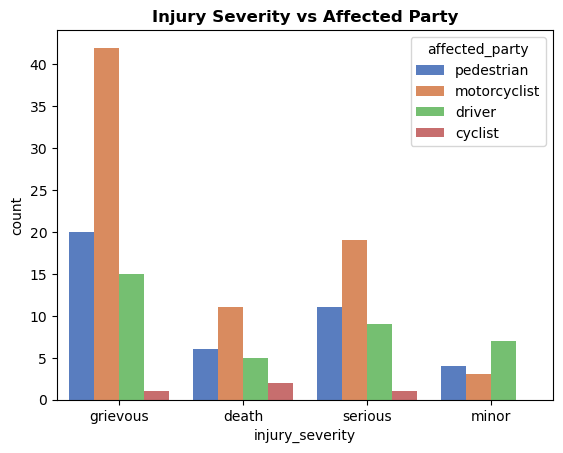

In [10]:
#1. Injury severity vs affected party
ax=sns.countplot(x="injury_severity", hue = 'affected_party', data=df, palette = "muted")
ax.set_title('Injury Severity vs Affected Party', fontsize=12, fontweight='bold')
plt.show()

#motorcyclists are fatalists

In [11]:
#accident severity vs vehicles involved
#encoding vehicle types in the following way: motorcycle - 1 , car - 2, larger vehicles - 3. A sum of the vehicle types is stored in a new column 'vehicle_type_score'"AI journal"
# if the sum is 1, it means only a motorcycle was involved, 2 - only a car, 3 - a car and a motorcycle or only a larger vehicle, 4 - a larger vehicle and a motorcycle, 5 - all three types

df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})

df['car'] = df['car'].replace({1:2, 0:0})
df['larger_vehicle'] = df['larger_vehicle'].replace({1:4, 0:0})
df['vehicle_type_score'] = df['car'] + df['motorbike'] + df['larger_vehicle'] 
df['primary_accident_type_code'].value_counts()
df['vehicle_type_score'].value_counts()

vehicle_type_score
2    57
3    53
1    21
6    14
7     6
5     3
0     2
Name: count, dtype: int64

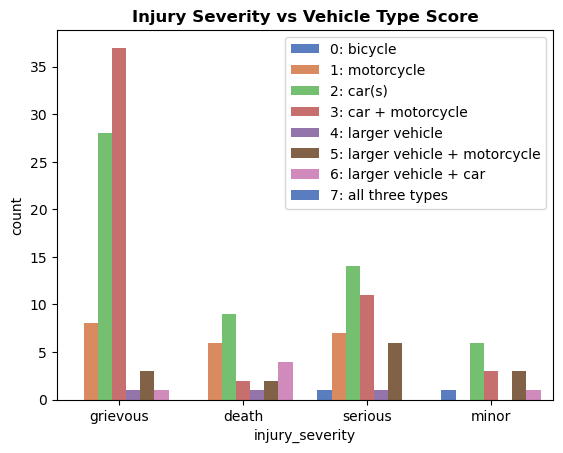

In [12]:
#injury severity vs vehicle type score
ax = sns.countplot(x="injury_severity", hue = 'vehicle_type_score', data=df, palette = "muted")
ax.set_title('Injury Severity vs Vehicle Type Score', fontsize=12, fontweight='bold')
ax.legend(labels = ['0: bicycle', '1: motorcycle', '2: car(s)', '3: car + motorcycle', '4: larger vehicle', '5: larger vehicle + motorcycle','6: larger vehicle + car', '7: all three types'], loc='best')
plt.show()

In [13]:
#correcting the accident type code based on the vehicle type score
idx_coll = df.loc[(df['vehicle_type_score']  > 2) & (df['larger_vehicle']==0)&(df['primary_accident_type_code'] != 'COLL')].index
df.loc[idx_coll, 'primary_accident_type_code'] = 'COLL'

In [14]:
#injuiry severity value counts
df['primary_accident_type_code'].value_counts()

#note: loc (lost control), roll (overturned) and other can be grouped together

primary_accident_type_code
COLL     74
PED      38
FXOBJ    31
OTH      13
Name: count, dtype: int64

In [15]:
df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})
df['primary_accident_type_code'].value_counts()

primary_accident_type_code
COLL     74
PED      38
FXOBJ    31
OTH      13
Name: count, dtype: int64

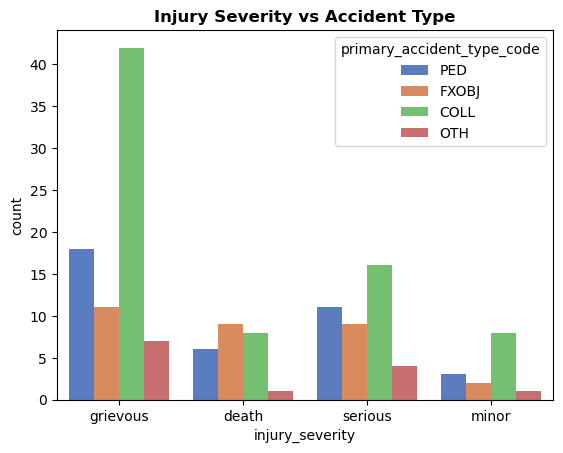

In [16]:
# 2. Injury severity vs primary accident type code
ax = sns.countplot(x="injury_severity", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Injury Severity vs Accident Type', fontsize=12, fontweight='bold')
plt.show()

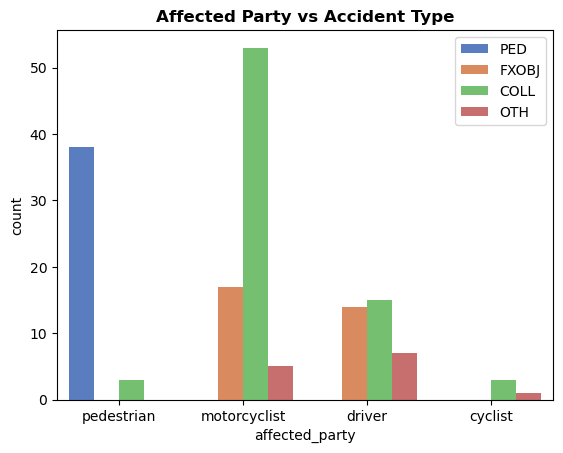

In [17]:
#3. Affected party vs primary accident type code
ax = sns.countplot(x="affected_party", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Affected Party vs Accident Type', fontsize=12, fontweight='bold')
ax.legend(loc='best')
plt.show()

#this shows that leading types of accidents for motorcyclysts are collision, followed by crushing into obstacles;
#for drivers, collisions and crushing into obstacles are equally frequent;
#the pedestrian category should have only one accident type - running over pedestrians, but since we joined it with the cyclist category, it shows collisions as well.

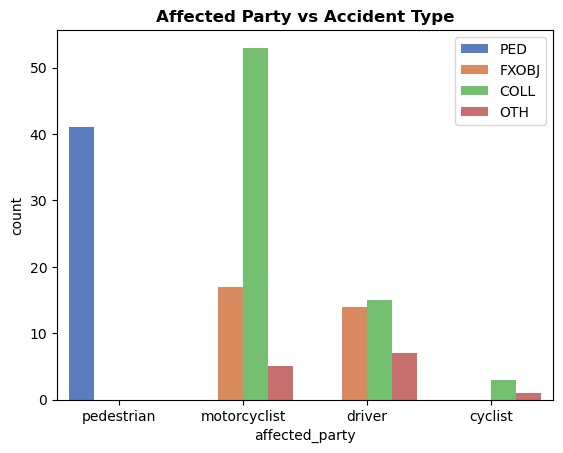

In [18]:
#correcting the accident type for pedestrians: all pedestrians are involved only in PED accidents
idx_ped = df.loc[(df['affected_party']  == 'pedestrian') & (df['primary_accident_type_code'] != 'PED')].index
df.loc[idx_ped, 'primary_accident_type_code'] = 'PED'

#3. Affected party vs primary accident type code
ax = sns.countplot(x="affected_party", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Affected Party vs Accident Type', fontsize=12, fontweight='bold')
ax.legend(loc='best')
plt.show()

C:\Users\renzo\AppData\Local\Temp\ipykernel_780\136133507.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="day_of_week_num", data=df, legend="False",palette = "muted")


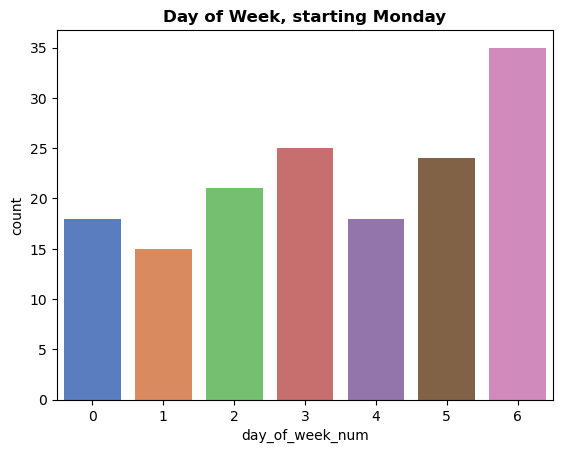

In [19]:
#day of week analysis
ax = sns.countplot(x="day_of_week_num", data=df, legend="False",palette = "muted")
ax.set_title('Day of Week, starting Monday', fontsize=12, fontweight='bold')
plt.show()


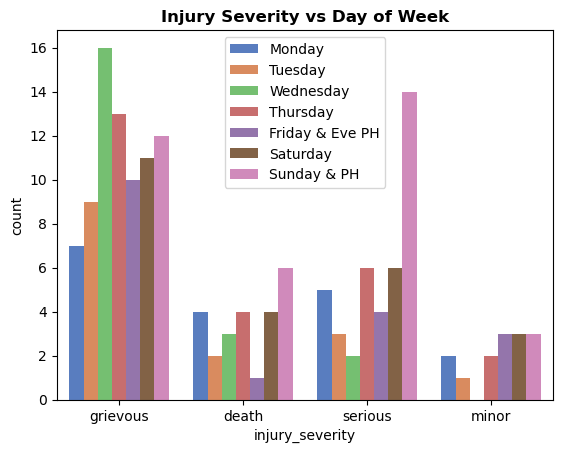

In [20]:
#5. Injury severity vs day of the week
ax = sns.countplot(x="injury_severity", hue = 'day_of_week_num', data=df, palette = "muted")
ax.set_title('Injury Severity vs Day of Week', fontsize=12, fontweight='bold')
ax.legend(labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday & Eve PH', 'Saturday','Sunday & PH'], loc='best')
plt.show()
#there're a peak midweek and on Sunday & there is a similarity between Monday&Tuesday and Friday & Saturday

<Axes: xlabel='injury_severity', ylabel='count'>

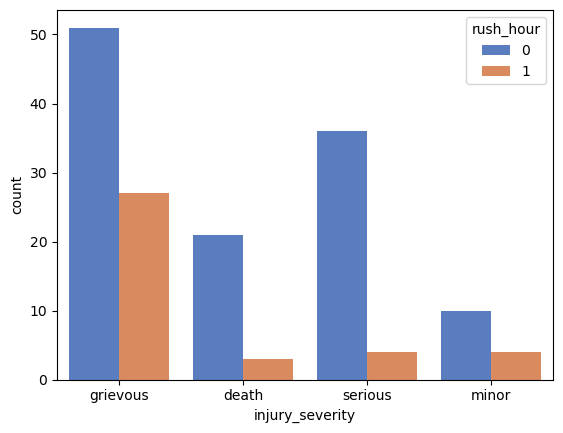

In [21]:
#4. Injury severity vs rush hour
sns.countplot(x="injury_severity", hue = 'rush_hour', data=df, palette = "muted")

<Axes: xlabel='primary_accident_type_code', ylabel='count'>

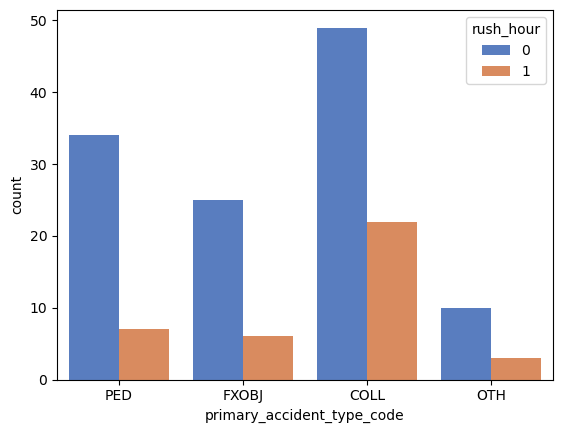

In [22]:
#4. Accident type vs rush hour
sns.countplot(x="primary_accident_type_code", hue = 'rush_hour', data=df, palette = "muted")

#the majority of collisions and running over pedestrians happen outside rush hour

<Axes: xlabel='primary_accident_type_code', ylabel='count'>

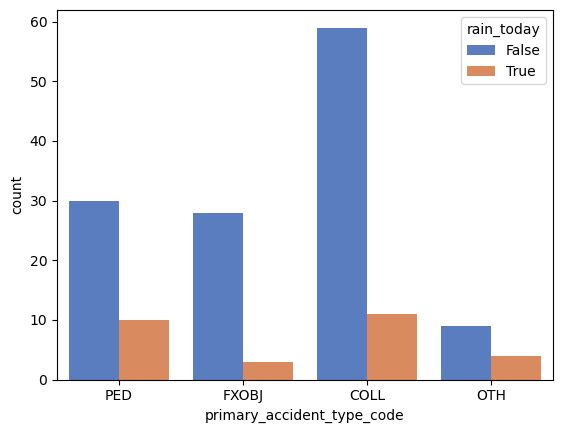

In [23]:
#5. Accident type vs rush hour
sns.countplot(x="primary_accident_type_code", hue = 'rain_today', data=df, palette = "muted")

<Axes: xlabel='injury_severity', ylabel='count'>

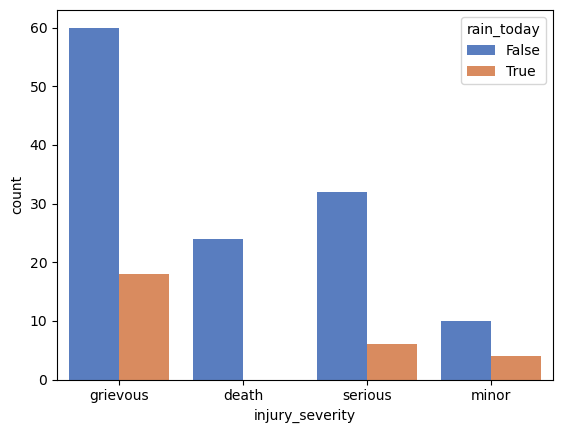

In [24]:
#5. Injury severity vs rush hour
sns.countplot(x="injury_severity", hue = 'rain_today', data=df, palette = "muted")

In [25]:
df['day_of_week_num'].value_counts()

day_of_week_num
6    35
3    25
5    24
2    21
4    18
0    18
1    15
Name: count, dtype: int64

<Axes: xlabel='injury_severity', ylabel='count'>

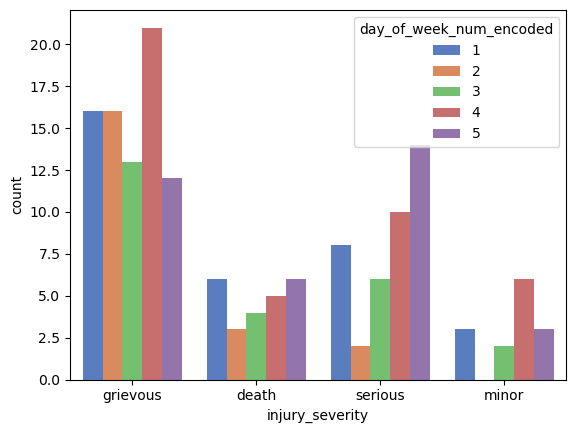

In [26]:
#encoding day of week this way: Monday (0) & Tuesday (1) = 1, Wednesday (2)  = 2 & Thursdays (3) are 3, Friday (4) & Saturday (5) is 4, Sunday (6) is 5
df['day_of_week_num_encoded'] = df['day_of_week_num'].replace({0:1, 1:1, 2:2, 3:3, 4:4, 5:4, 6:5})
sns.countplot(x="injury_severity", hue = 'day_of_week_num_encoded', data=df, palette = "muted")

In [27]:
#since grievous injuries with motorcyclists and collisions are the most frequent, we can reduce these to balance the dataset
idx_GriMotoColl = df.loc[(df['injury_severity']  == 'grievous') & (df['affected_party']  == 'motorcyclist') & (df['primary_accident_type_code'] != 'FXOBJ')].index
#idx_GriMotoColl = df.loc[(df['injury_severity']  == 'grievous') & (df['affected_party']  == 'motorcyclist') & (df['primary_accident_type_code'] != 'COLL')].index
idx_GriMotoColl


Index([ 21,  23,  24,  27,  28,  30,  31,  35,  38,  51,  54,  55,  58,  60,
        61,  66,  68,  69,  71,  72,  77,  79,  84,  87,  93,  95,  96,  98,
       100, 114, 118, 122, 130, 131, 140, 144, 149, 151],
      dtype='int64')

In [28]:
idx_GriMotoColl.size
#there are a lot of records of grievously injuired motorcyclists who crushed into fixed objects
#how to handle unbalanced data:
# https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/
#we can divide grievous and serious class in two groups and use the two minority classes with each of those two groups
#https://www.youtube.com/watch?v=ok2s1vV9XW0

38

In [29]:
df['hour'] = pd.to_datetime(df['time_24h'], format='%H:%M', errors='coerce').dt.hour
display(df['hour'])

0      11
1      17
2      17
3      19
4      19
       ..
151     5
152    23
153     9
154     9
155     9
Name: hour, Length: 156, dtype: int32

In [30]:
## The time-of-day categories were created using the cut method
df['time_period'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 17, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

In [31]:
df.drop(columns=['hour'], inplace=True)
print(df[['time_24h', 'time_period']].head())

  time_24h time_period
0    11:15     Morning
1    17:00     Evening
2    17:30     Evening
3    19:45     Evening
4    19:45     Evening


In [32]:
## Time Period Value Counts
df['time_period'].value_counts()

time_period
Morning      55
Evening      50
Afternoon    36
Night        15
Name: count, dtype: int64

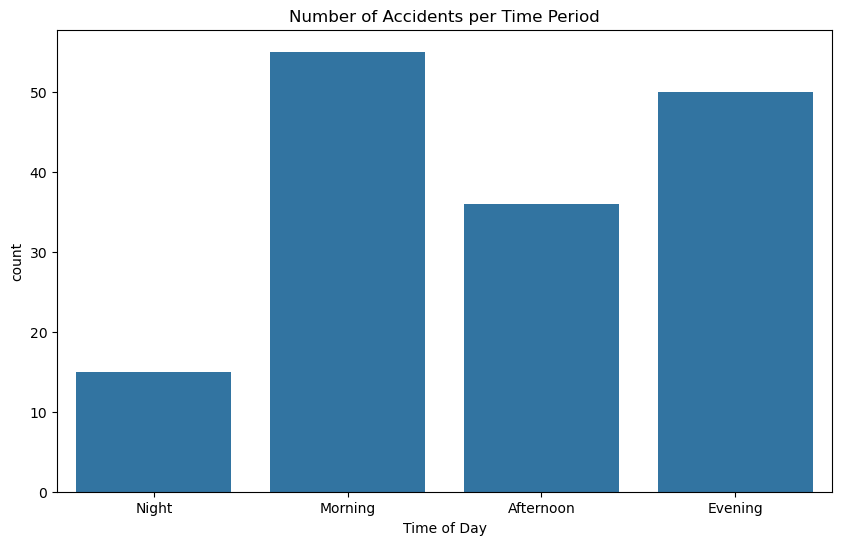

In [33]:
## Time Period Analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='time_period')
plt.xlabel('Time of Day')
plt.title('Number of Accidents per Time Period')
plt.show()

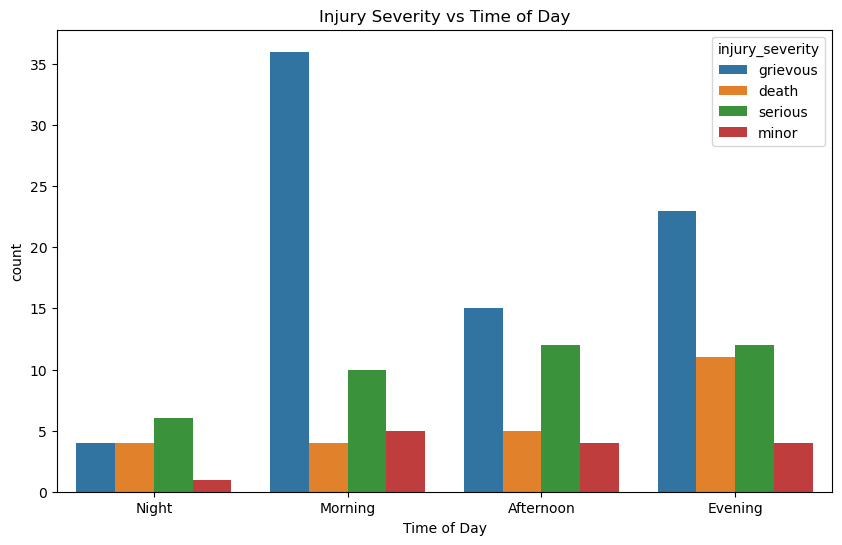

In [34]:
#6. Injury Severity vs Time of Day
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='time_period',
    hue='injury_severity'
)
plt.xlabel('Time of Day')
plt.title('Injury Severity vs Time of Day')
plt.show()

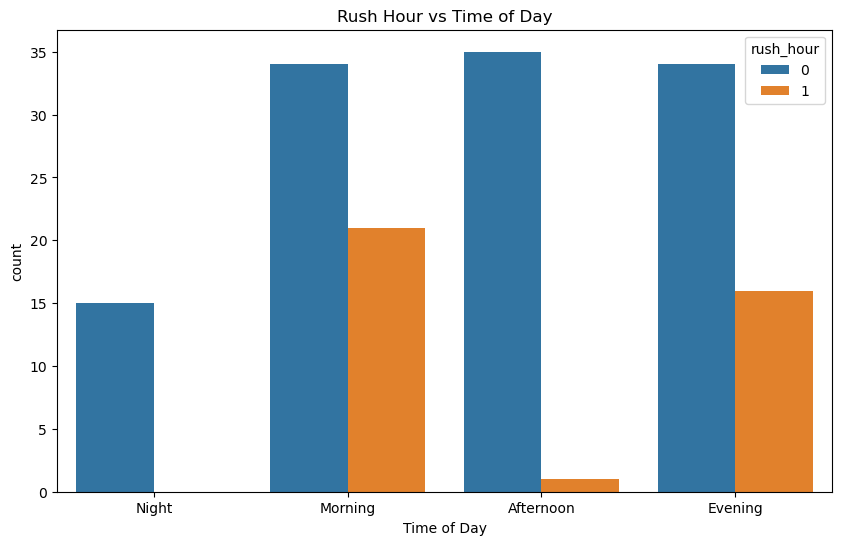

In [35]:
##7. Rush Hour vs Time of Day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='time_period', hue='rush_hour')
plt.xlabel('Time of Day')
plt.title('Rush Hour vs Time of Day')
plt.show()

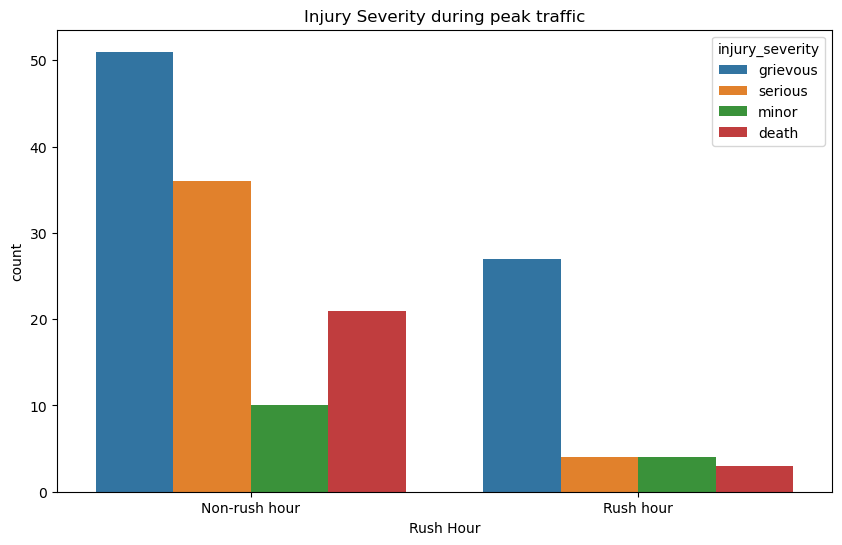

In [36]:
## Evaluating Injury Severity During Peak Traffic
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rush_hour', hue='injury_severity')
plt.xticks([0, 1], ['Non-rush hour', 'Rush hour'])
plt.xlabel('Rush Hour')
plt.title('Injury Severity during peak traffic')
plt.show()

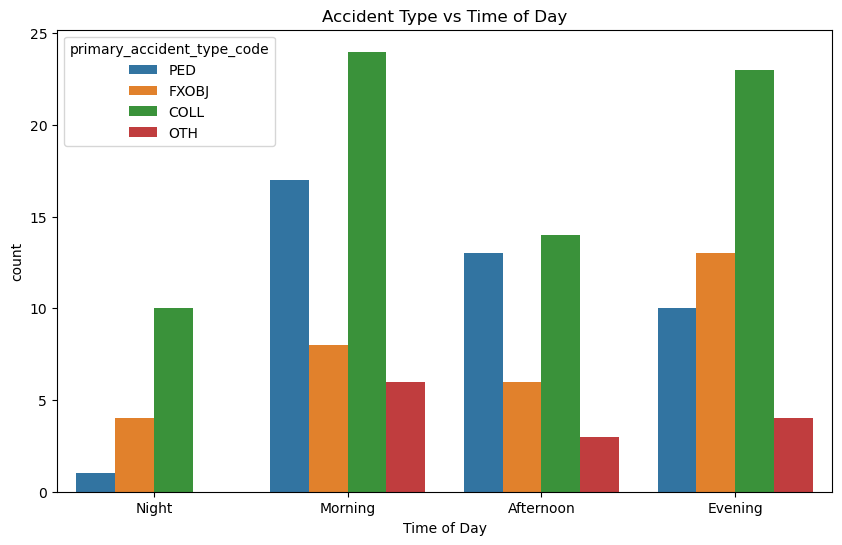

In [37]:
##8. Accident Type vs Time of Day
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='time_period',
    hue='primary_accident_type_code'
)
plt.xlabel('Time of Day')
plt.title('Accident Type vs Time of Day')
plt.show()

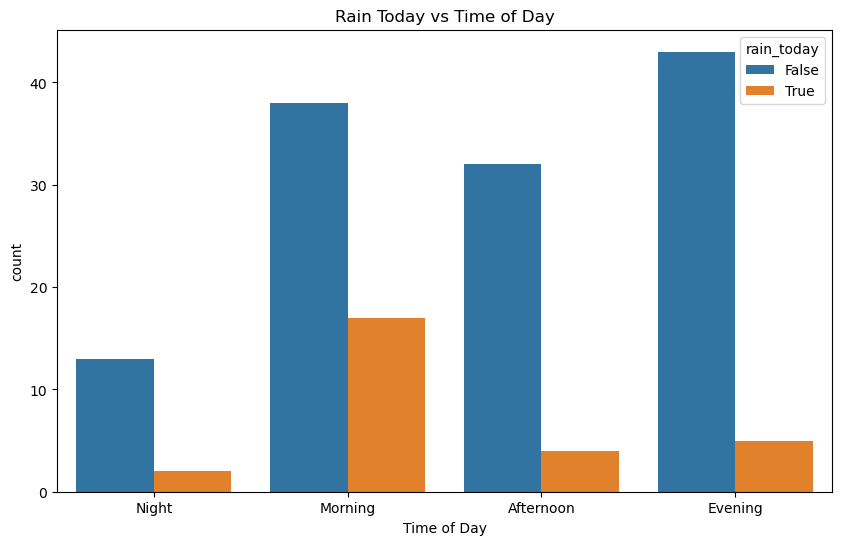

In [38]:
##9. Rain Today vs Time of Day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='time_period', hue='rain_today')
plt.xlabel('Time of Day')
plt.title('Rain Today vs Time of Day')
plt.show()